In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import random

class IDBSCANSampler:
    def __init__(self, eps, min_samples):
        """
        eps: O raio de vizinhança (mesmo que o epsilon do DBSCAN)
        min_samples: Densidade mínima (mesmo que minPts do DBSCAN)
        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaders_indices = []
        self.followers_map = {} # {leader_idx: [list_of_follower_indices]}
        self.point_membership_count = {} # {point_idx: count_of_leaders_it_follows}

    def _modified_leader_algorithm(self, X):
        """
        Implementação do Algoritmo 3 (Modified Leader)
        Passo 1: Encontrar Líderes
        Passo 2: Associar seguidores a TODOS os líderes próximos (interseções)
        """
        n_samples = X.shape[0]
        leaders = []
        
        # --- Passo 1: Identificar Líderes (Leader Clássico) ---
        # Usamos uma lista simples para manter a ordem e lógica do paper
        # Para datasets gigantes, usar uma Spatial Index (KDTree) seria melhor
        for i in range(n_samples):
            point = X[i]
            is_follower = False
            
            # Verifica se está perto de algum líder existente
            # Nota: Otimização possível com RadiusNeighbors, mas fazemos loop para clareza
            for l_idx in leaders:
                dist = np.linalg.norm(X[l_idx] - point)
                if dist <= self.eps:
                    is_follower = True
                    break # No Leader clássico, paramos no primeiro.
            
            if not is_follower:
                leaders.append(i)
        
        self.leaders_indices = leaders
        
        # --- Passo 2: Mapear Seguidores e Interseções (Modified Version) ---
        # Agora verificamos a quais líderes cada ponto pertence (pode ser > 1)
        self.followers_map = {l: [] for l in leaders}
        self.point_membership_count = np.zeros(n_samples, dtype=int)
        
        # Usamos NearestNeighbors para encontrar rapidamente todos os líderes num raio eps
        # Construímos a árvore apenas com os líderes para busca rápida
        nbrs = NearestNeighbors(radius=self.eps, metric='euclidean')
        nbrs.fit(X[leaders])
        
        # Para cada ponto no dataset, ver quem são os seus líderes
        # radius_neighbors retorna os indices dentro da lista 'leaders', não indices originais
        dists, param_leaders_indices = nbrs.radius_neighbors(X)
        
        for point_idx, local_leader_idxs in enumerate(param_leaders_indices):
            # local_leader_idxs são posições no array self.leaders_indices
            
            # Contar a quantos líderes este ponto pertence
            self.point_membership_count[point_idx] = len(local_leader_idxs)
            
            for local_idx in local_leader_idxs:
                real_leader_idx = self.leaders_indices[local_idx]
                
                # Se o ponto não é o próprio líder, adiciona como seguidor
                if point_idx != real_leader_idx:
                    self.followers_map[real_leader_idx].append(point_idx)

    def _fft_sampling(self, points_indices, X, k):
        """
        Farthest-First Traversal Sampling
        Seleciona k pontos que estão o mais distantes possível uns dos outros.
        """
        if k >= len(points_indices):
            return points_indices
        
        # Subset de dados
        candidates = X[points_indices]
        n_candidates = len(points_indices)
        
        # 1. Escolher o primeiro aleatoriamente
        selected_local_indices = [random.randint(0, n_candidates - 1)]
        
        # Manter distâncias mínimas para os pontos selecionados
        # Inicializar com distância ao primeiro ponto selecionado
        min_dists = np.linalg.norm(candidates - candidates[selected_local_indices[0]], axis=1)
        
        for _ in range(1, k):
            # 2. Escolher o ponto com a maior distância mínima (o mais isolado)
            next_idx = np.argmax(min_dists)
            selected_local_indices.append(next_idx)
            
            # 3. Atualizar as distâncias mínimas considerando o novo ponto escolhido
            new_dists = np.linalg.norm(candidates - candidates[next_idx], axis=1)
            min_dists = np.minimum(min_dists, new_dists)
            
        return [points_indices[i] for i in selected_local_indices]

    def fit_sample(self, X):
        """
        Executa o Algoritmo 4 (I-DBSCAN Sampling)
        Retorna: indices dos pontos selecionados para a amostra final S
        """
        # 1. Executar Modified Leader (Linha 1 do Algoritmo 4)
        self._modified_leader_algorithm(X)
        
        # 2. Inicializar S com todos os Líderes (Linha 2)
        sample_set = set(self.leaders_indices)
        
        # 3. Iterar sobre cada Líder (Linha 3)
        for l in self.leaders_indices:
            followers = self.followers_map[l]
            
            # Identificar seguidores que estão em intersecções (seguem > 1 líder)
            # s <- Find all followers of l in any intersection (Linha 4)
            intersection_followers = [f for f in followers if self.point_membership_count[f] > 1]
            non_intersection_followers = [f for f in followers if self.point_membership_count[f] == 1]
            
            num_followers = len(followers)
            num_intersections = len(intersection_followers)
            
            # Linha 5: if |Fl| > minPts
            if num_followers > self.min_samples:
                
                # Linha 6: if |s| > minPts (Muitas interseções)
                if num_intersections > self.min_samples:
                    # Linha 7: s <- FFT-SAMPLING(s, minPts)
                    sampled_s = self._fft_sampling(intersection_followers, X, self.min_samples)
                    sample_set.update(sampled_s)
                    
                else:
                    # Linha 8/9: else (Poucas interseções)
                    # s <- s U SAMPLE(Fl, minPts - |s|)
                    # Guardamos TODAS as interseções
                    sample_set.update(intersection_followers)
                    
                    # Completamos com aleatórios dos NÃO-interseção
                    needed = self.min_samples - num_intersections
                    if needed > 0 and len(non_intersection_followers) >= needed:
                        random_sample = random.sample(non_intersection_followers, needed)
                        sample_set.update(random_sample)
                    elif needed > 0:
                        # Se não houver suficientes, leva tudo o que há
                        sample_set.update(non_intersection_followers)

            else:
                # O paper diz (Linha 265): "Se líder tem menos que minPts, 
                # todos os seguidores em intersecções são adicionados".
                sample_set.update(intersection_followers)

        return sorted(list(sample_set))

# --- EXEMPLO DE USO ---

# 1. Criar dados fictícios
from sklearn.datasets import make_blobs
data, _ = make_blobs(n_samples=1000, centers=3, cluster_std=0.5, random_state=42)

# 2. Configurar parâmetros do DBSCAN
eps = 0.3
min_pts = 10

# 3. Executar o I-DBSCAN Sampler
print("A executar I-DBSCAN Sampling...")
idbscan = IDBSCANSampler(eps=eps, min_samples=min_pts)
sample_indices = idbscan.fit_sample(data)

# 4. Resultados da Amostragem
sample_data = data[sample_indices]
reduction = 100 * (1 - len(sample_data) / len(data))

print(f"Dados Originais: {len(data)} pontos")
print(f"Amostra Gerada: {len(sample_data)} pontos")
print(f"Redução de Tamanho: {reduction:.2f}%")

# 5. Executar DBSCAN REAL sobre a amostra (o passo final)
dbscan = DBSCAN(eps=eps, min_samples=min_pts)
labels_sample = dbscan.fit_predict(sample_data)

print(f"Clusters encontrados na amostra: {len(set(labels_sample)) - (1 if -1 in labels_sample else 0)}")

A executar I-DBSCAN Sampling...
Dados Originais: 1000 pontos
Amostra Gerada: 507 pontos
Redução de Tamanho: 49.30%
Clusters encontrados na amostra: 3


In [ ]:
import os
import sys
from IPython.display import display, Markdown
import pandas as pd 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler


#.experimentsv2 import Experiment
root_path = os.path.abspath("..")  
if root_path not in sys.path:
    sys.path.insert(0, root_path)
os.chdir("..")


In [ ]:
from data.loader import load_complete_dataset


In [8]:
from data.preprocessing import add_module_columns


dataset=load_complete_dataset()
add_module_columns(dataset)

,device_id,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,timestamp,actitivy_label,participant_id,magnetometer_module,gyroscope_module,accelerometer_module
0,1.0,-2.82430,9.1773,2.2388,-1.43340,-0.003309,-0.41384,-0.85484,0.50402,0.674830,1735.1,1.0,14,1.200076,1.491948,9.859601
1,1.0,-2.80020,9.1655,2.2507,-1.04340,0.230960,-0.12186,-0.85887,0.52610,0.674830,1754.6,1.0,14,1.212367,1.075582,9.844448
2,1.0,-2.78810,9.1296,2.2634,-1.12080,0.215210,-0.10277,-0.85081,0.52811,0.683740,1774.2,1.0,14,1.212550,1.145893,9.810509
3,1.0,-2.82400,9.1173,2.2522,-1.15170,0.143390,0.32778,-0.84879,0.50402,0.688200,1793.7,1.0,14,1.203370,1.205991,9.806760
4,1.0,-2.82400,9.1414,2.2517,-1.36180,-0.113230,0.65311,-0.86290,0.51807,0.683740,1813.2,1.0,14,1.216755,1.514554,9.829055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53114,5.0,-0.48220,9.4431,-2.1914,0.70696,-0.734460,1.05760,-0.13535,0.71257,0.069565,1038000.0,1.0,0,0.728639,1.468925,9.706023
53115,5.0,-0.47013,9.4553,-2.1919,0.23155,-0.340820,0.98911,-0.12525,0.67265,0.071739,1038000.0,1.0,0,0.687962,1.071500,9.717415
53116,5.0,-0.49463,9.4428,-2.2155,0.53524,-0.291600,1.00350,-0.11919,0.69461,0.071739,1038000.0,1.0,0,0.708404,1.174106,9.711826
53117,5.0,-0.47013,9.4553,-2.1919,0.23140,-0.326390,0.89815,-0.11313,0.72056,0.084783,1038100.0,1.0,0,0.734298,0.983234,9.717415


In [ ]:
dataset[["accelerometer_module","gyroscope_module","magnetometer_module"]]

,accelerometer_module,gyroscope_module,magnetometer_module
0,9.859601,1.491948,1.200076
1,9.844448,1.075582,1.212367
2,9.810509,1.145893,1.212550
3,9.806760,1.205991,1.203370
4,9.829055,1.514554,1.216755


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Certifique-se de que a classe IDBSCANSampler está importada ou definida antes disto!
# from sua_biblioteca import IDBSCANSampler 

# ==============================================================================
# 1. PREPARAÇÃO DOS DADOS
# ==============================================================================
# Assumindo que 'dataset' já está carregado como DataFrame
print(f"Shape original do dataset: {dataset.shape}")

# Seleção das 3 colunas (Se quiser usar as 550, teria de mudar esta linha)
X_real = dataset[["accelerometer_module", "gyroscope_module", "magnetometer_module"]].to_numpy()

# Normalizar (Crítico: coloca média=0 e desvio padrão=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_real)

# --- PARÂMETROS CORRIGIDOS ---
# Como os dados estão normalizados (escala pequena), o EPS tem de ser pequeno.
# 0.5 é um bom valor de partida para dados com StandardScaler.
REAL_EPS = 0.5   # <--- ALTERADO: De 20.0 para 0.5
REAL_MIN_PTS = 100 # <--- ALTERADO: De 10 para 100 (melhor para 4 milhões de dados)

# ==============================================================================
# 2. EXECUTAR I-DBSCAN SAMPLING
# ==============================================================================
print(f"A processar dataset de {X_scaled.shape} com EPS={REAL_EPS}...")
sampler = IDBSCANSampler(eps=REAL_EPS, min_samples=REAL_MIN_PTS)
sample_indices = sampler.fit_sample(X_scaled)

X_sample = X_scaled[sample_indices]

reduction_pct = 100 * (1 - len(X_sample) / len(X_real))

print("-" * 30)
print(f"Redução Alcançada:")
print(f"Original: {len(X_real)} linhas")
print(f"Amostra : {len(X_sample)} linhas")
print(f"Removido: {reduction_pct:.2f}% (Pontos agrupados nos líderes)")
print("-" * 30)

# ==============================================================================
# 3. CLUSTERING NA AMOSTRA
# ==============================================================================
if len(X_sample) > 0:
    print("A executar DBSCAN na amostra reduzida...")
    dbscan = DBSCAN(eps=REAL_EPS, min_samples=REAL_MIN_PTS)
    sample_labels = dbscan.fit_predict(X_sample)

    # ==============================================================================
    # 4. PROPAGAÇÃO DAS LABELS (Líderes -> Seguidores)
    # ==============================================================================
    # Inicializa tudo como -1 (Ruído)
    final_labels = np.full(X_scaled.shape[0], -1)

    # Atribui labels aos líderes (pontos da amostra)
    final_labels[sample_indices] = sample_labels

    # Mapa auxiliar para consulta rápida: {indice_lider: label_cluster}
    sample_label_map = {idx: lbl for idx, lbl in zip(sample_indices, sample_labels)}

    print("A propagar labels para os seguidores...")
    
    # Itera sobre os líderes encontrados pelo Sampler
    # Nota: sampler.leaders_indices deve conter os índices originais dos líderes
    for leader_idx in sampler.leaders_indices:
        
        # Verifica se este líder tem uma label válida (não é ruído na amostra)
        if leader_idx in sample_label_map:
            leader_label = sample_label_map[leader_idx]
            
            # Se o próprio líder for ruído (-1), os seguidores também serão (já são -1 por padrão)
            if leader_label == -1:
                continue

            # Recupera os seguidores deste líder
            followers = sampler.followers_map[leader_idx]
            
            # Atribui a label do líder a todos os seguidores
            # (Usar indexação direta de numpy é mais rápido que loop for)
            if len(followers) > 0:
                final_labels[followers] = leader_label

    # ==============================================================================
    # 5. RESULTADOS FINAIS
    # ==============================================================================
    n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
    n_noise = list(final_labels).count(-1)
    noise_pct = (n_noise / len(final_labels)) * 100

    print("\n" + "=" * 30)
    print(f"RESULTADO FINAL (I-DBSCAN completo):")
    print(f"Clusters Encontrados: {n_clusters}")
    print(f"Pontos Ruído (-1)   : {n_noise} ({noise_pct:.2f}%)")
    print("=" * 30)

else:
    print("ERRO: A amostragem removeu todos os pontos (Amostra vazia). Ajuste o EPS.")

Shape original do dataset: (3930798, 16)
A processar dataset de (3930798, 3) com EPS=0.5...
------------------------------
Redução Alcançada:
Original: 3930798 linhas
Amostra : 122945 linhas
Removido: 96.87% (Pontos agrupados nos líderes)
------------------------------
A executar DBSCAN na amostra reduzida...
A propagar labels para os seguidores...

RESULTADO FINAL (I-DBSCAN completo):
Clusters Encontrados: 1
Pontos Ruído (-1)   : 7576 (0.19%)


In [13]:
pip install plotly

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------  9.7/9.9 MB 60.9 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 50.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Amostrando 10000 pontos para visualização (de 3930798 totais)...
A gerar gráfico interativo Plotly...


A gerar gráfico estático Matplotlib...


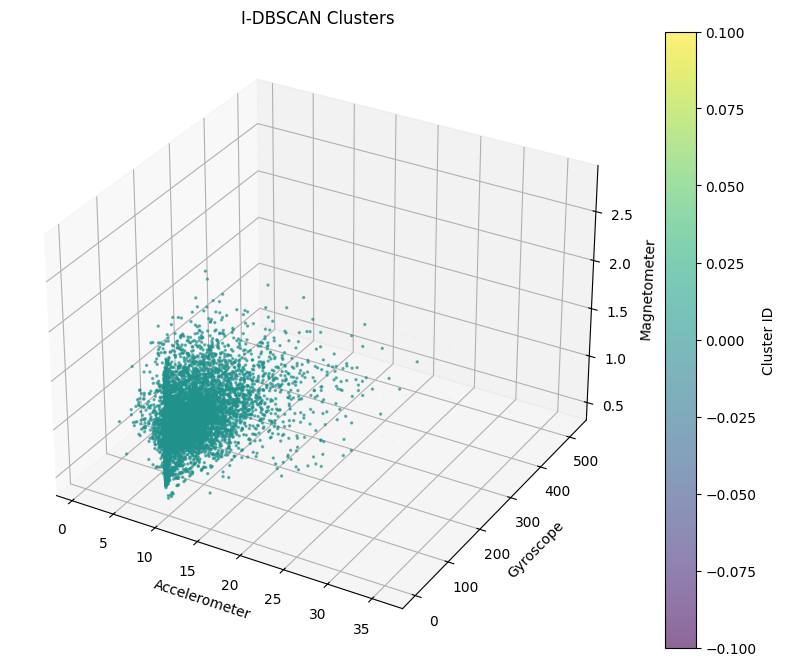

In [14]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PREPARAR DADOS PARA O PLOT
# ==============================================================================
# Vamos criar um DataFrame temporário apenas para visualização
# Usamos os dados REAIS (X_real) para os eixos terem significado físico
# Mas usamos as LABELS (final_labels) que acabaste de calcular
df_plot = pd.DataFrame(X_real, columns=["accelerometer", "gyroscope", "magnetometer"])
df_plot['Cluster'] = final_labels

# --- PASSO CRÍTICO: AMOSTRAGEM PARA VISUALIZAÇÃO ---
# Plotar 4 milhões de pontos vai bloquear o browser ou o Python.
# Vamos pegar em 10.000 pontos aleatórios para visualizar a estrutura.
N_SAMPLES_PLOT = 10000 

if len(df_plot) > N_SAMPLES_PLOT:
    print(f"Amostrando {N_SAMPLES_PLOT} pontos para visualização (de {len(df_plot)} totais)...")
    df_vis = df_plot.sample(n=N_SAMPLES_PLOT, random_state=42)
else:
    df_vis = df_plot

# Converter a coluna Cluster para string para que o gráfico a trate como categoria (cores discretas)
# E ordenamos para que o ruído (-1) apareça primeiro ou separado
df_vis['Cluster'] = df_vis['Cluster'].astype(str)
df_vis = df_vis.sort_values('Cluster')

# ==============================================================================
# OPÇÃO A: PLOTLY (Recomendado - Interativo)
# ==============================================================================
print("A gerar gráfico interativo Plotly...")
fig = px.scatter_3d(
    df_vis, 
    x='accelerometer', 
    y='gyroscope', 
    z='magnetometer',
    color='Cluster',
    title=f"Clustering I-DBSCAN (Amostra de {N_SAMPLES_PLOT} pontos)",
    opacity=0.7,
    size_max=5,
    # Mapa de cores: Ruído (-1) a cinzento, outros com cores vivas
    color_discrete_map={'-1': 'lightgrey'} 
)

# Ajustar o tamanho dos marcadores
fig.update_traces(marker=dict(size=3))
fig.show()

# ==============================================================================
# OPÇÃO B: MATPLOTLIB (Estático - Bom para guardar imagem)
# ==============================================================================
print("A gerar gráfico estático Matplotlib...")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Separar ruído dos clusters para pintar diferente
mask_noise = df_vis['Cluster'] == '-1'
data_noise = df_vis[mask_noise]
data_clusters = df_vis[~mask_noise]

# Plotar Ruído (Cinzento e transparente)
ax.scatter(
    data_noise['accelerometer'], 
    data_noise['gyroscope'], 
    data_noise['magnetometer'], 
    c='lightgrey', label='Ruído (-1)', alpha=0.1, s=1
)

# Plotar Clusters (Colorido por label)
# Convertemos labels de volta para int para usar o cmap 'tab10' ou 'viridis'
if not data_clusters.empty:
    scatter = ax.scatter(
        data_clusters['accelerometer'], 
        data_clusters['gyroscope'], 
        data_clusters['magnetometer'], 
        c=data_clusters['Cluster'].astype(int), 
        cmap='viridis', s=2, alpha=0.6
    )
    plt.colorbar(scatter, label='Cluster ID')

ax.set_xlabel('Accelerometer')
ax.set_ylabel('Gyroscope')
ax.set_zlabel('Magnetometer')
plt.title('I-DBSCAN Clusters')
plt.show()

In [15]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PROPAGAÇÃO DAS LABELS (Líderes -> Seguidores)
# ==============================================================================
print("A iniciar a propagação das labels para o dataset completo...")

# Inicializa array final com -1 (Tudo começa como ruído)
# X_real é o teu dataset original (3 milhões de linhas)
final_labels = np.full(len(X_real), -1)

# Passo A: Atribuir labels aos pontos da amostra (Líderes)
final_labels[sample_indices] = sample_labels

# Passo B: Criar mapa para consulta rápida {indice_lider: label_cluster}
sample_label_map = {idx: lbl for idx, lbl in zip(sample_indices, sample_labels)}

# Passo C: Propagar para os seguidores
# sampler.leaders_indices contém os índices dos líderes identificados na fase 1
count_propagated = 0

for leader_idx in sampler.leaders_indices:
    
    # Verificamos se este líder ficou com uma label válida (não é ruído)
    if leader_idx in sample_label_map:
        leader_label = sample_label_map[leader_idx]
        
        # Se o próprio líder for ruído (-1), ignoramos (os seguidores mantêm-se -1)
        if leader_label == -1:
            continue
            
        # Buscar a lista de seguidores deste líder
        followers = sampler.followers_map[leader_idx]
        
        if len(followers) > 0:
            # Atribuição direta (Vetorizada é mais rápida)
            final_labels[followers] = leader_label
            count_propagated += len(followers)

print(f"Propagação concluída: {count_propagated} pontos recuperados através dos líderes.")

# ==============================================================================
# 2. CRIAR DATAFRAME FINAL
# ==============================================================================
# Vamos criar um DataFrame limpo com as features originais e a nova label
# Assumindo que 'dataset' é o teu DataFrame original com nomes das colunas
df_final = pd.DataFrame(X_real, columns=["accelerometer_module", "gyroscope_module", "magnetometer_module"])
df_final['Cluster'] = final_labels

# Estatísticas Finais
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
n_noise = list(final_labels).count(-1)
perc_noise = (n_noise / len(final_labels)) * 100

print("-" * 30)
print(f"ESTATÍSTICAS FINAIS DO DATASET ({len(df_final)} linhas):")
print(f"Total Clusters: {n_clusters}")
print(f"Ruído (-1)    : {n_noise} ({perc_noise:.2f}%)")
print("-" * 30)

# ==============================================================================
# 3. GUARDAR EM FICHEIRO (CSV)
# ==============================================================================
filename = "resultado_clustering_idbscan.csv"
print(f"A guardar ficheiro '{filename}'... (isto pode demorar um pouco)")

# index=False para não guardar o número da linha
df_final.to_csv(filename, index=False)

print("Sucesso! Ficheiro guardado.")

A iniciar a propagação das labels para o dataset completo...
Propagação concluída: 10095078 pontos recuperados através dos líderes.
------------------------------
ESTATÍSTICAS FINAIS DO DATASET (3930798 linhas):
Total Clusters: 1
Ruído (-1)    : 7576 (0.19%)
------------------------------
A guardar ficheiro 'resultado_clustering_idbscan.csv'... (isto pode demorar um pouco)
Sucesso! Ficheiro guardado.


In [17]:
df_final['Cluster'].value_counts()

Cluster
 0    3923222
-1       7576
Name: count, dtype: int64